Installing pydicom for dicom images

In [ ]:
pip install pydicom

Import Dependencies

In [ ]:
import pydicom as dicom
import numpy as np
from skimage import filters, morphology
import matplotlib.pyplot as plt
import cv2

Function: load_dicom_image(dicom_path)


*   dicom_path (str)



In [ ]:
def load_dicom_image(dicom_path):
    ds = dicom.dcmread(dicom_path)
    image = ds.pixel_array.astype(float)
    inverted_image = np.max(image) - image
    return inverted_image

Function: apply_otsu_threshold(image)

*   image (numpy.ndarray)



In [ ]:
def apply_otsu_threshold(image):
    threshold_value = filters.threshold_otsu(image)
    binary_image = image > threshold_value
    return binary_image

Function: apply_median_filter(image, kernel_size)

*   image (numpy.ndarray)
*   kernel_size (int)



In [ ]:
def apply_median_filter(image, kernel_size=50):
    median_filtered = filters.median(image, morphology.disk(kernel_size))
    return median_filtered

Function: apply_median_filter(image, kernel_size)

*   edge (numpy.ndarray)

In [ ]:
def post_process(edge):
  kernel_size = 10
  kernel = np.ones((kernel_size, kernel_size), np.uint8)
  mdst = cv2.dilate(edge, kernel, iterations=1)

  mask = np.zeros_like(mdst)
  x, y, w, h = 200, 265, 1700, 1250
  mask[y:y+h, x:x+w] = mdst[y:y+h, x:x+w]

  height, width = mask.shape[:2]
  temp = np.zeros_like(mask)
  cv2.rectangle(temp, (1500, 210), (2000, 340), (255, 255, 255), thickness=cv2.FILLED)
  temp = cv2.bitwise_not(temp)
  process_result = cv2.bitwise_and(mask, temp)

  return process_result

Function: apply_canny_edge_detector(image, low_threshold, high_threshold)

*   image (numpy.ndarray),
*   low_threshold (int, default value = 1)
*   high_threshold (int, default value = 1)

In [ ]:
def apply_canny_edge_detector(image, low_threshold=1, high_threshold=1):
    edges = cv2.Canny(image.astype(np.uint8), low_threshold, high_threshold)
    dilated = post_process(edges)
    return edges

Function: plot_images(images, titles)

*   images (list of numpy.ndarray)
*   titles (list of str)

In [ ]:
def plot_images(images, titles):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

    for i in range(num_images):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(titles[i])


    plt.show()

Function: hough_line(median_filtered_image,image_copy)

*   median_filtered_image (numpy.ndarray)
*   iamge_copy (nump.ndarray)

In [ ]:
def hough_line(median_filtered_image,image_copy):
  temp = cv2.imwrite("temp.png",image_copy)
  original_image = cv2.imread("temp.png")
  gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

  #Apply edge detection
  edges = apply_canny_edge_detector(median_filtered_image)
  edges = post_process(edges)

  #Draw lines on the original image
  line_image = np.copy(image_copy)

  #Params for hough
  rho = 1
  theta = np.pi/90
  threshold = 20
  min_line_length = 5
  max_line_gap = 1

  #Run Hough
  lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                          min_line_length, max_line_gap)

  #Iterate over the output "lines" and draw lines on the image copy
  for line in lines:
      for x1,y1,x2,y2 in line:
          cv2.line(line_image,(x1,y1),(x2,y2),(0,255,255),5)

  return line_image

Function: eval(image1,image2)

*   image1 (numpy.ndarray)
*   image2 (nump.ndarray)

In [ ]:
def eval(image1,image2):
    #Compute the intersection and union of binary images
    intersection = np.logical_and(image1,image2)
    union = np.logical_or(image1,image2)

    #Calculate
    jaccard_similarity_index = np.sum(intersection) / np.sum(union)

    return jaccard_similarity_index

Testing

In [ ]:
def main():
    #load image
    dicom_path = '/content/9a10650e-5e39-474b-a741-72b6ae0a311f.dcm'
    dicom_image = load_dicom_image(dicom_path)

    #apply threshold
    thresholded_image = apply_otsu_threshold(dicom_image)
    median_filtered_image = apply_median_filter(thresholded_image)

    #get edges using canny, use hough transformation, add morphology (dilation) and contour
    hough = hough_line(median_filtered_image,dicom_image)

    #evaluate result using jaccard index
    score = eval(dicom_image,hough)
    print("Jaccard INdex:",score)

    #display orig, edge detected, and hough result
    temp = apply_canny_edge_detector(median_filtered_image)
    temp = post_process(temp)
    images = [dicom_image, temp,hough]
    titles = ['Original DICOM Image','Edge Detected','Hough Result']

    plot_images(images, titles)

Jaccard INdex: 0.975831278540207


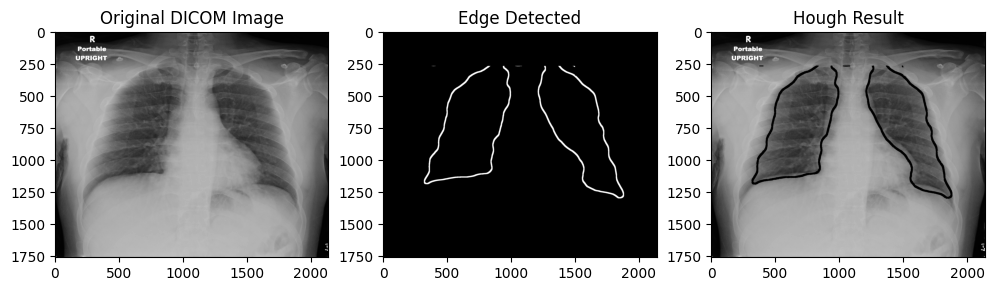

In [ ]:
main()

Reference
1. Jadwaa, S. A. K. (2022). X-Ray Lung Image Classification Using a Canny Edge Detector. Journal of Electrical and Computer Engineering, 2022.
2. https://wttech.blog/blog/2022/edge-detection-and-processing-using-canny-edge-detector-and-hough-transform/